In [15]:
%pwd
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
#from pyspark.ml.classification import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

### Load Data

In [4]:
raw_train = spark.read.option("sep", "\t").csv("gs://80-629bucket/dat/criteo/data.txt", inferSchema=True)
raw_train = raw_train.cache()

### Pre-process data

In [5]:
raw_train_full = raw_train.fillna(0.1)

In [6]:
raw_train_full.count()

45840617

In [7]:
raw_train.describe(["_c0", "_c1", "_c2", "_c3"]).show()

+-------+------------------+------------------+------------------+------------------+
|summary|               _c0|               _c1|               _c2|               _c3|
+-------+------------------+------------------+------------------+------------------+
|  count|          45840617|          25047061|          45840617|          36001170|
|   mean|0.2562233837297609|3.5024133170754044|105.84841979766546|26.913041020611274|
| stddev|0.4365466361308114| 9.429076407105068| 391.4578226870709|397.97258302273343|
|    min|                 0|                 0|                -3|                 0|
|    max|                 1|              5775|            257675|             65535|
+-------+------------------+------------------+------------------+------------------+



In [8]:
#raw_train.describe("_c0").show()
#raw_train_full = raw_train_full.withColumn('label', (raw_train_full._c0 > 0).cast("int"))
#print(raw_train_full.count())

In [9]:
assembler = VectorAssembler(
    inputCols=["_c1", "_c2", "_c3", "_c4", "_c5", "_c6", "_c7", "_c8", "_c9", "_c10", "_c11", "_c12"],
    outputCol="features")

# Spark: Transformer
raw_data_features = assembler.transform(raw_train_full)
output_ = raw_data_features.select("_c0","features")

print('number of examples: ', output_.count())

print(output_.head(10))

number of examples:  45840617
[Row(_c0=0, features=DenseVector([1.0, 1.0, 5.0, 0.0, 1382.0, 4.0, 15.0, 2.0, 181.0, 1.0, 2.0, 0.0])), Row(_c0=0, features=DenseVector([2.0, 0.0, 44.0, 1.0, 102.0, 8.0, 2.0, 2.0, 4.0, 1.0, 1.0, 0.0])), Row(_c0=0, features=DenseVector([2.0, 0.0, 1.0, 14.0, 767.0, 89.0, 4.0, 2.0, 245.0, 1.0, 3.0, 3.0])), Row(_c0=0, features=SparseVector(12, {1: 893.0, 4: 4392.0})), Row(_c0=0, features=SparseVector(12, {0: 3.0, 1: -1.0, 4: 2.0, 6: 3.0, 9: 1.0, 10: 1.0})), Row(_c0=0, features=SparseVector(12, {1: -1.0, 4: 12824.0, 8: 6.0})), Row(_c0=0, features=SparseVector(12, {1: 1.0, 2: 2.0, 4: 3168.0, 7: 1.0, 8: 2.0})), Row(_c0=1, features=SparseVector(12, {0: 1.0, 1: 4.0, 2: 2.0, 6: 1.0, 9: 1.0, 10: 1.0})), Row(_c0=0, features=DenseVector([0.0, 44.0, 4.0, 8.0, 19010.0, 249.0, 28.0, 31.0, 141.0, 0.0, 1.0, 0.0])), Row(_c0=0, features=DenseVector([0.0, 35.0, 0.0, 1.0, 33737.0, 21.0, 1.0, 2.0, 3.0, 0.0, 1.0, 0.0]))]


### Split Train/Test

In [10]:
(trainingData, testData) = output_.randomSplit([0.9, 0.1])
trainingData = trainingData.cache()
testData = testData.cache()
print('train size:', trainingData.count())
print('test size:', testData.count())

train size: 41255651
test size: 4584966


### Train logistic regression model

In [11]:
stime = time.time()

# ML model (Spark: estimator)
lr = LogisticRegression(maxIter=100, regParam=1e-10, labelCol="_c0")
# Fit the model
lrModel = lr.fit(trainingData)
etime = time.time()
print('Elapsed time: %.3f seconds' % (etime-stime)) 

Elapsed time: 40.633 seconds


### Iterations

objectiveHistory:
0 0.5691069258913035
1 0.5549827944687944
2 0.5423720516435322
3 0.5397960766369744
4 0.5386946905229483
5 0.5385758953810765
6 0.538470190181823
7 0.5384230099835767
8 0.5383677162964634
9 0.5383329720387219
10 0.5383283343558296
11 0.5383279064070904
12 0.5383278374137921
13 0.5383277506498904
14 0.5383277069077383
15 0.5383277018928259
16 0.5383277008852546
17 0.5383277007277508
18 0.5383277005758531
19 0.5383277005231083
20 0.5383277005131621
21 0.5383277005086056


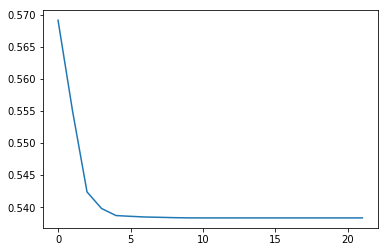

In [12]:
trainingSummary = lrModel.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
objectives = []
for i, objective in enumerate(objectiveHistory):
    print(i, objective)
    objectives.append(objective)
    
plt.plot(np.arange(len(objectives)), np.array(objectives))
plt.show()

# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
#trainingSummary.roc.show()
#print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

### Explore trained model

In [13]:
# Print the coefficients and intercept for logistic regression
print(lrModel.coefficientMatrix)
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

#print("lrModel was fit using parameters: ")
#print(lrModel.extractParamMap())

DenseMatrix([[  7.23768337e-03,   1.47586658e-04,   1.02208080e-04,
               -2.01836583e-02,  -3.72183812e-06,  -5.75158880e-04,
               -2.20907122e-03,  -1.06814144e-02,   5.65470616e-06,
                5.07626629e-01,   5.95487132e-02,   3.07151972e-02]])
Coefficients: [0.00723768336571,0.000147586657843,0.000102208080257,-0.0201836582754,-3.72183812415e-06,-0.000575158880462,-0.00220907122013,-0.0106814144048,5.65470616265e-06,0.507626628779,0.0595487131591,0.0307151971702]
Intercept: -1.1005271025328507


### Predictions

In [16]:
predictions = lrModel.transform(testData)

#testData.describe().show()
predictions.describe().show()

# Select example rows to display.
#predictions.select("prediction", "_c0", "features").show(50)

# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
lr.setThreshold(bestThreshold)


evaluator = MulticlassClassificationEvaluator(
    labelCol="_c0", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Logistic Regression\nTest Error = %g " % (1.0 - accuracy))

+-------+-------------------+-------------------+
|summary|                _c0|         prediction|
+-------+-------------------+-------------------+
|  count|            4584966|            4584966|
|   mean|0.25590745929195546|0.03542120050617605|
| stddev|0.43637011022964606|0.18484195008910198|
|    min|                  0|                0.0|
|    max|                  1|                1.0|
+-------+-------------------+-------------------+

Logistic Regression
Test Error = 0.253252 


## Decision tree

In [17]:
stime = time.time()

# ML model (Spark: estimator)
dt = DecisionTreeClassifier(labelCol="_c0", featuresCol="features")
# Fit the model
dtModel = dt.fit(trainingData)
etime = time.time()
print('Elapsed time: %.3f seconds' % (etime-stime))

Elapsed time: 18.815 seconds


In [18]:
print(dtModel.numNodes)
print(dtModel.depth)
print(dtModel.featureImportances)

63
5
(12,[0,2,3,4,5,6,7,8,10],[0.362085102677,0.0308000146908,0.026081081763,0.017491095317,0.265703987045,0.0338906179492,0.031822641098,0.0124551478223,0.219670311638])


In [19]:
predictions = dtModel.transform(testData)

# Select example rows to display.
predictions.select("prediction", "_c0", "features").show(5)

+----------+---+----------+
|prediction|_c0|  features|
+----------+---+----------+
|       0.0|  0|(12,[],[])|
|       0.0|  0|(12,[],[])|
|       0.0|  0|(12,[],[])|
|       0.0|  0|(12,[],[])|
|       0.0|  0|(12,[],[])|
+----------+---+----------+
only showing top 5 rows



In [20]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="_c0", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Decision Tree\nTest Error = %g " % (1.0 - accuracy))

#treeModel = dtModel.stages[2]
# summary only
print(dtModel)

Decision Tree
Test Error = 0.244372 
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_4105a2600173c6b8f8cd) of depth 5 with 63 nodes


### Use all features

In [21]:
#from pyspark.ml import Pipeline
#from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Load the data stored in CSV format as a DataFrame.
data = spark.read.option("sep", "\t").csv("gs://80-629bucket/dat/criteo/data.txt", inferSchema=True)

data = data.fillna(0.1)
data = VectorAssembler(
    inputCols=["_c1", "_c2", "_c3", "_c4", "_c5", "_c6", "_c7", "_c8", "_c9", "_c10",\
               "_c11", "_c12", "_c13", "_c14", "_c15", "_c16", "_c17", "_c18",  "_c19",\
               "_c20",  "_c21",  "_c22",  "_c23",  "_c24",  "_c25",  "_c26",  "_c27",\
               "_c28",  "_c29",  "_c30",  "_c31",  "_c32",  "_c33",  "_c34",  "_c35",\
               "_c36",  "_c37",  "_c38"],
    outputCol="features").transform(data)

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
#labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(data)
# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(data) #, maxCategories=4).fit(data)

data = featureIndexer.transform(data)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Train a logistic regression model
#dt = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")
lr = LogisticRegression(maxIter=10, regParam=0.01, featuresCol="indexedFeatures", labelCol="_c0")
# Fit the model
#lrModel = lr.fit(output_)

# Chain indexers and logistic regressos in a Pipeline
#pipeline = Pipeline(stages=[featureAssembler, featureIndexer, lr])

# Train model.  This also runs the indexers.
#model = pipeline.fit(trainingData)

lrModel = lr.fit(trainingData)

# Make predictions.
predictions = lr.transform(testData)

# Select example rows to display.
predictions.select("prediction", "indexedLabel", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g " % (1.0 - accuracy))

treeModel = model.stages[2]
# summary only
print(treeModel)

IllegalArgumentException: 'Data type StringType is not supported.'

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

dataset = spark.createDataFrame(
    [(0, 18, 1.0, Vectors.dense([0.0, 10.0, 0.5]), 1)],
    ["id", "hour", "mobile", "userFeatures", "clicked"])

print(dataset.printSchema())

assembler = VectorAssembler(
    inputCols=["hour", "mobile", "userFeatures"],
    outputCol="features")

output = assembler.transform(dataset)
print("Assembled columns 'hour', 'mobile', 'userFeatures' to vector column 'features'")
output.select("features", "clicked").show(truncate=False)

print(output.printSchema())

stime = time.time()
lr = LogisticRegression(maxIter=2, regParam=0.3, elasticNetParam=0.8, labelCol="clicked")
# Fit the model
lrModel = lr.fit(output)
etime = time.time()
print('total time: %.3f seconds' % (etime-stime)) 

# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

In [ ]:
a = sc.textFile('gs://80-629bucket/dat/criteo/')

In [ ]:
a.take(10)

In [ ]:
from pyspark.ml.classification import LogisticRegression

# Load training data
training = spark.read.format("libsvm").load("gs://80-629bucket/dat/mllib/sample_libsvm_data.txt")

lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(training)

# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

# We can also use the multinomial family for binary classification
mlr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial")

# Fit the model
mlrModel = mlr.fit(training)

# Print the coefficients and intercepts for logistic regression with multinomial family
print("Multinomial coefficients: " + str(mlrModel.coefficientMatrix))
print("Multinomial intercepts: " + str(mlrModel.interceptVector))

In [ ]:
print(training.show())
print(training.schema)